In [104]:
#all imports
import networkx as nx
import matplotlib.pyplot as plt
import random 
from string import ascii_lowercase
import numpy as np
import time
import math
import datetime
from bokeh.models import CustomJS, Slider, Button
from bokeh.layouts import row, column
from bokeh.plotting import show
from bokeh.io import output_notebook
from datetime import timedelta, date
import warnings
warnings.simplefilter('ignore')

In [105]:
output_notebook()
#city class struct
class Ville:
    def __init__(self,identifiant, x, y,name):
        self.identifiant = identifiant
        self.x = x
        self.y = y
        self.name = name
        
    def showDatas(self):
        print('Ville :',self.name,' id:',self.identifiant,'; X:',self.x,'; Y:',self.y)

#road class struct
class Route:
    def __init__(self,identifiant, id_ville_1, id_ville_2):
        self.identifiant = identifiant
        self.id_ville_1 = id_ville_1
        self.id_ville_2 = id_ville_2
        
    def showDatas(self):
        print('Route : id:',self.identifiant,'; Ville 1:',self.id_ville_1,'; Ville 2:',self.id_ville_2)
        
class Trafic:
    def __init__(self,identifiant, id_route, date, nbr_vehicules):
        self.identifiant = identifiant
        self.id_route = id_route
        self.date = date
        self.nbr_vehicules = nbr_vehicules
        
    def showDatas(self):
        print('Trafic :',self.identifiant,' id route:',self.id_route,'; date:',self.date,'; Nbr véhicules:',self.nbr_vehicules)

#to reload cities name file txt
def reloadCitiesName():
    citiesName = []
    try:
        with open('FrenchCitieslist.txt', 'rU') as infile:
            wordSet = set(line.strip() for line in infile)
    except IOError:
           print('error opening file')

    for aWord in wordSet:
        citiesName.append(aWord)
    return citiesName

#calculate distance between two points
def calculateDistance(x1,y1,x2,y2):  
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
    return dist  

#sanitize too close cities
def sanitiseCityCoords(x,y):
    minDist = minDistBetweenCities
    maxIterations = 5000
    currentIteration = 0
    conflict = False
    
    for ville in villes:
        if calculateDistance(x,y,ville.x,ville.y) <= minDist:
            conflict = True
    
    while conflict == True:
        
        random.seed(time.clock())
        conflict = False
        x,y = (random.randint(minX,maxX),random.randint(minY,maxY))
        
        for ville in villes:
            if calculateDistance(x,y,ville.x,ville.y) <= minDist:
                conflict = True  
                
        if currentIteration <= maxIterations:
            currentIteration += 1
        else:
            minDist = minDist - minDist / 100 #Exemple of temporal complexity reduction
    return(x,y)

def sanitiseRoad(x,y):
    maxIterations = 5000
    currentIteration = 0
    conflict = False
    
    if x == y:
        conflict = True
    
    for route in routes:
        if (x == route.id_ville_1 and y == route.id_ville_2) or (y == route.id_ville_1 and x == route.id_ville_2):
            #print("CONFLICT : X=",x, " Y=",y, " villeX=",route.id_ville_1," villeY=",route.id_ville_2 )
            conflict = True
    
    while conflict == True:
        random.seed(time.clock())
        conflict = False
        x,y = (random.randint(0,nbr_villes),random.randint(0,nbr_villes))
        for road in routes:
            if (x == route.id_ville_1 and y == route.id_ville_2) or (y == route.id_ville_1 and x == route.id_ville_2) or (x == y):
                conflict = True
               
        if currentIteration <= maxIterations:
            currentIteration = currentIteration + 1
        else:
            x,y = (random.randint(0,nbr_villes),random.randint(0,nbr_villes))
            conflict = False
    return(x,y)

def generateGraph():

    #Generate cities and associated nodes
    for i in range(0,nbr_villes+1):
        selection = random.randint(0, len(citiesName)-1)
        name = citiesName.pop(selection)

        #position
        x,y = sanitiseCityCoords(random.randint(minX,maxX),random.randint(minY,maxY))

        ville = Ville(i,x,y,name)
        villes.append(ville)
        G.add_node(i,pos=(x,y))
        labels[i] = ville.name
        

    #Generate roads and associated edges
    for i in range(0,nbr_routes):
        id_ville_1,id_ville_2 = sanitiseRoad(random.randint(0,nbr_villes),random.randint(0,nbr_villes))
        routes.append(Route(i,id_ville_1,id_ville_2))
        G.add_edge(id_ville_1,id_ville_2)    

    #Draw Graph
    plt.figure(figsize=(15, 15))
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.xlim(minX,maxX)
    plt.ylim(minY,maxY)
    plt.title("Carte routière")
    ax = plt.subplot(1,1,1)
    pos = nx.get_node_attributes(G,'pos')

    #TODO : need to implement dynamic scale of node size for big amount of cities, same for roads
    nx.draw_networkx(G,pos,node_size=1000,node_color="skyblue", alpha=0.5,node_shape="s", linewidths=30, ax =ax)
    nx.draw_networkx_labels(G, pos, labels, font_size=16,font_weight='bold')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    plt.show()

Loading BokehJS ...

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    https://docs.bokeh.org/en/latest/docs/user_guide/server.html



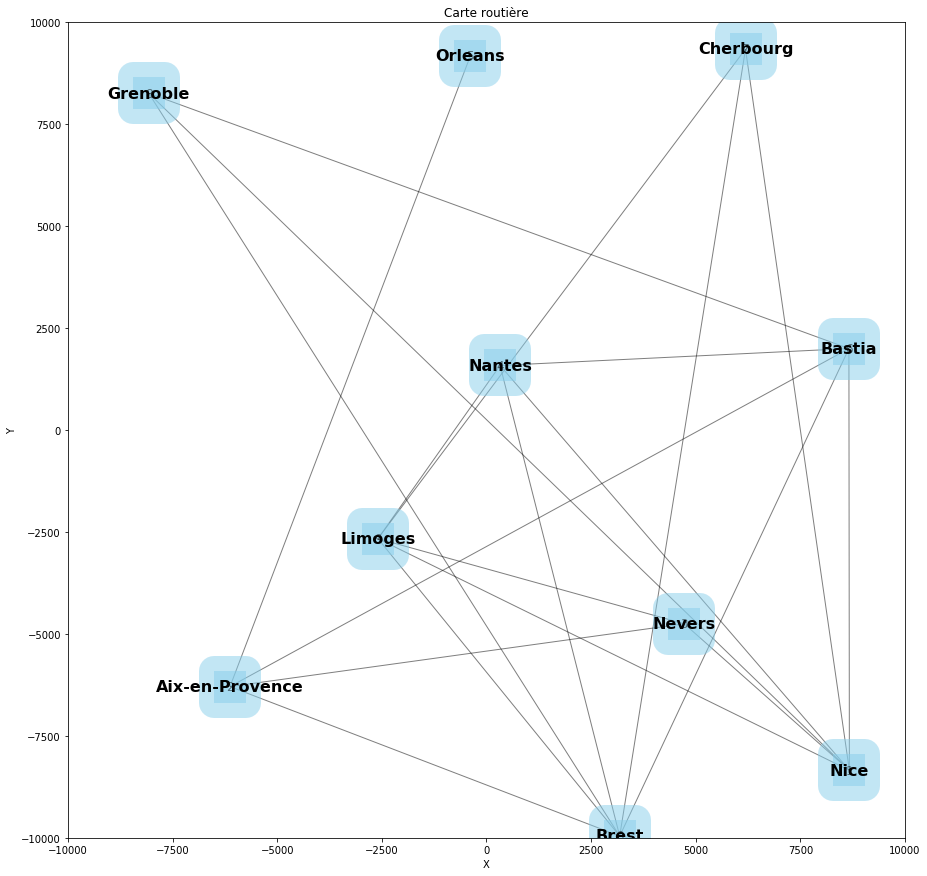

Time of Execution :
Wall time: 567 ms


In [106]:
%%time 

#magic execution time

def change_click():
    generateGraph()

cities_slider = Slider(start=1, end=100, value=1, step=1, title="Nombre de villes")
roads_slider = Slider(start=1, end=500, value=1, step=.1, title="Nombre de routes")
maxX_slider = Slider(start=0, end=10000, value=5000, step=100, title="MaxX")
minX_slider = Slider(start=-10000, end=0, value=-5000, step=100, title="MinX")
maxY_slider = Slider(start=0, end=10000, value=5000, step=100, title="MaxY")
minY_slider = Slider(start=-10000, end=0, value=-5000, step=100, title="MinY")
bt = Button(label='Generate')

bt.on_click(change_click)


layout = row(
    column(cities_slider, roads_slider, maxX_slider, minX_slider,maxY_slider,minY_slider),bt
)

nbr_villes = 10;
nbr_routes = 20;
nbr_trafic_record = 5000;

startDate = datetime.datetime(2020,1,1, 7, 0)
endDate = datetime.datetime(2020,1, 5, 19, 0)

#Not absolute if too long time execution, it's a preferred dist, reducing by 1% each iterations after 5000 iterations
minDistBetweenCities = 5000; 

#range
maxX = 10000;
maxY = 10000;
minX = -10000;
minY = -10000;
villes = []
routes = []
labels = {}
G = nx.Graph()
nbr_villes = nbr_villes-1 #to fix fucked up bug of NetworkX
citiesName = reloadCitiesName()


show(layout)

generateGraph()


print("Time of Execution :") #don't delete, using magic cell statement